# Project - Predictability for Volatility and Mean

In [1]:
import numpy as np
import pandas as pd 
import math
from random import gauss
from math import sqrt
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import log, sqrt, exp
from scipy.stats import norm
from glob import glob
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import warnings
import os
from functools import reduce
warnings.filterwarnings("ignore")

# Data Acquisition and Cleaning - 10 years daily from NASDAQ 100 Technology Sector 

In [2]:
# function for reading files
def read_file(f):
    df = pd.read_csv(f)
    df['ticker'] = f.split('.')[0].strip('^')
    return df

# function for getting log-returns
def getlogret(data):
    logret = np.log(data) - np.log(data.shift(1))
    return logret

In [3]:
# create the dataframe for closing price, named as 'close'
close = pd.concat([read_file(f) for f in glob('*.csv')])
close = close.set_index(['Date','ticker'])[['Close']].unstack()
# extract the tickers for renaming purpose later
tickers = close.columns.get_level_values('ticker')
close

Close                                                    \
ticker            AAPL        AMD        BIDU        GOOGL          IXIC   
Date                                                                       
2011-06-01   12.339643   8.370000  132.470001   263.063049   2769.189941   
2011-06-02   12.360714   8.240000  138.490005   264.294281   2773.310059   
2011-06-03   12.265714   7.970000  133.210007   261.801788   2732.780029   
2011-06-06   12.072857   7.800000  126.970001   260.790802   2702.560059   
2011-06-07   11.858571   7.710000  124.820000   259.774780   2701.560059   
...                ...        ...         ...          ...           ...   
2021-05-24  127.099998  77.440002  188.960007  2361.040039  13661.169922   
2021-05-25  126.900002  77.860001  192.770004  2362.870117  13657.169922   
2021-05-26  126.849998  78.339996  194.880005  2380.310059  13738.000000   
2021-05-27  125.279999  78.419998  194.809998  2362.679932  13736.280273   
2021-05-28  124.610001  80.080002  196.270004  2356.850098  13748.740234   

                                                                         \
ticker            MSFT         NDXT        NVDA        NXPI        QCOM   
Date                                                                      
2011-06-01   24.430000  1433.280029   19.139999   27.100000   57.150002   
2011-06-02   24.219999  1438.209961   19.049999   26.510000   57.799999   
2011-06-03   23.910000  1409.640015   18.459999   26.700001   57.040001   
2011-06-06   24.010000  1396.780029   18.070000   26.549999   56.480000   
2011-06-07   24.059999  1397.560059   18.059999   26.580000   56.509998   
...                ...          ...         ...         ...         ...   
2021-05-24  250.779999  8000.270020  624.479980  204.380005  132.910004   
2021-05-25  251.720001  8033.209961  625.909973  204.759995  133.750000   
2021-05-26  251.490005  8053.779785  628.000000  206.139999  133.089996   
2021-05-27  249.309998  8019.879883  619.520020  210.220001  133.639999   
2021-05-28  249.679993  8064.850098  649.780029  211.419998  134.539993   

                                    
ticker            SWKS         TXN  
Date                                
2011-06-01   24.559999   33.950001  
2011-06-02   24.920000   34.240002  
2011-06-03   23.059999   33.500000  
2011-06-06   23.280001   33.320000  
2011-06-07   25.080000   33.270000  
...                ...         ...  
2021-05-24  168.880005  188.690002  
2021-05-25  170.029999  188.699997  
2021-05-26  168.850006  188.360001  
2021-05-27  170.869995  189.130005  
2021-05-28  170.000000  189.820007  

[2516 rows x 12 columns]

In [4]:
# create the dataframe for logreturns, named as 'logret'
logret = close
for i in range(0,len(close.axes[1])):
    logret.iloc[:,i] = getlogret(close.iloc[:,i])
logret = logret.iloc[1:].rename(columns={'Close': 'Logret'})

In [5]:
logret = logret.round(20) # make sure the precision in data is not lost throughout the process of predicting
logret

Logret                                                    \
ticker          AAPL       AMD      BIDU     GOOGL      IXIC      MSFT   
Date                                                                     
2011-06-02  0.001706 -0.015654  0.044442  0.004669  0.001487 -0.008633   
2011-06-03 -0.007715 -0.033316 -0.038871 -0.009475 -0.014722 -0.012882   
2011-06-06 -0.015848 -0.021561 -0.047976 -0.003869 -0.011120  0.004174   
2011-06-07 -0.017909 -0.011606 -0.017078 -0.003904 -0.000370  0.002080   
2011-06-08  0.000602 -0.011742 -0.033813  0.000270 -0.009738 -0.005000   
...              ...       ...       ...       ...       ...       ...   
2021-05-24  0.013226  0.003493 -0.003012  0.028749  0.014019  0.022624   
2021-05-25 -0.001575  0.005409  0.019962  0.000775 -0.000293  0.003741   
2021-05-26 -0.000394  0.006146  0.010886  0.007354  0.005901 -0.000914   
2021-05-27 -0.012454  0.001021 -0.000359 -0.007434 -0.000125 -0.008706   
2021-05-28 -0.005362  0.020947  0.007467 -0.002471  0.000907  0.001483   

                                                                        
ticker          NDXT      NVDA      NXPI      QCOM      SWKS       TXN  
Date                                                                    
2011-06-02  0.003434 -0.004713 -0.022012  0.011309  0.014552  0.008506  
2011-06-03 -0.020065 -0.031461  0.007142 -0.013236 -0.077571 -0.021849  
2011-06-06 -0.009165 -0.021353 -0.005634 -0.009866  0.009495 -0.005388  
2011-06-07  0.000558 -0.000554  0.001129  0.000531  0.074476 -0.001502  
2011-06-08 -0.015089 -0.027507 -0.043443 -0.003723 -0.026668 -0.018199  
...              ...       ...       ...       ...       ...       ...  
2021-05-24  0.018961  0.040540  0.022464  0.010970  0.012993  0.019696  
2021-05-25  0.004109  0.002287  0.001858  0.006300  0.006786  0.000053  
2021-05-26  0.002557  0.003334  0.006717 -0.004947 -0.006964 -0.001803  
2021-05-27 -0.004218 -0.013595  0.019599  0.004124  0.011892  0.004080  
2021-05-28  0.005592  0.047689  0.005692  0.006712 -0.005105  0.003642  

[2515 rows x 12 columns]

# Data Analysis - use the historical data to predict the future

## Volatility 

In [6]:
# Define functions for actual/predicted volatility and the absolute error between them

def volpred(df, n): # function for prediction
    # keep the index for non-overlapped rolling window. eg for a=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], a[2::3]=[2, 5, 8]
    return (df.rolling(n).std()[n-1::n])*np.sqrt(260) # change to annualized volatility

def volerr(df, n): # function for residual error (Actual-Prediction)
    df_volpred = volpred(df, n) 
    df_volerr = df_volpred.shift(-1) - df_volpred
    df_volerr = df_volerr.iloc[:-1] # delete the last NaN row
    df_volerr.columns = pd.MultiIndex.from_product([['Residual Error (Volatility)'], tickers])
    return df_volerr

def volabserr(df, n): # function for absolute error (|Actual-Prediction|)
    df_volpred = volpred(df, n)
    df_volabserr = (df_volpred.shift(-1) - df_volpred).abs()
    df_volabserr = df_volabserr.iloc[:-1] # delete the last NaN row
    df_volabserr.columns = pd.MultiIndex.from_product([['Absolute Error (Volatility)'], tickers])
    return df_volabserr

In [7]:
# Define error functions, relative errors, taking size of error into account

def volAPE(df,n): # use absolute percentage error
    df_volpred = volpred(df, n)
    df_volact = df_volpred.shift(-1)
    df_volerr = (df_volpred - df_volact).iloc[:-1]  # delete the last NaN row
    df_volpred.columns = tickers
    df_volact.columns = tickers
    df_volerr.columns = tickers
    df_volAPE = (df_volerr.div(df_volact.iloc[:-1])).abs() # abs((actual-pred)/actual) 
    df_volAPE.columns=pd.MultiIndex.from_product([['APE (Volatility)'], df_volAPE.columns])
    return df_volAPE

def volAMPE(df,n): # use absolute mean percentage error
    df_volpred = volpred(df, n)
    df_volact = df_volpred.shift(-1)
    df_volerr = (df_volpred - df_volact).iloc[:-1]  # delete the last NaN row
    df_volpred.columns = tickers
    df_volact.columns = tickers
    df_volerr.columns = tickers
    avg = (df_volact.iloc[:-1] + df_volpred.iloc[:-1]) / 2   # exclude the last NaN rows
    df_volAMPE = (df_volerr.div(avg)).abs() # abs((actual-pred)/avg)
    df_volAMPE.columns=pd.MultiIndex.from_product([['AMPE (Volatility)'], df_volAMPE.columns])
    return df_volAMPE

## Mean 

In [8]:
# Define functions for actual/predicted mean and the absolute error between them

def meanpred(df, n): # function for prediction
    return (df.rolling(n).mean()[n-1::n])*260 # change to annualized mean

def meanerr(df, n): # function for residual error (Actual-Prediction)
    df_meanpred = meanpred(df, n)
    df_meanerr = (df_meanpred.shift(-1) - df_meanpred)
    df_meanerr = df_meanerr.iloc[:-1] # delete the last NaN row
    df_meanerr.columns=pd.MultiIndex.from_product([['Residual Error (Mean)'], tickers])
    return df_meanerr 

def meanabserr(df, n): # function for residual error (|Actual-Prediction|)
    df_meanpred = meanpred(df, n)
    df_meanabserr = (df_meanpred.shift(-1) - df_meanpred).abs()
    df_meanabserr = df_meanabserr.iloc[:-1] # delete the last NaN row
    df_meanabserr.columns=pd.MultiIndex.from_product([['Absolute Error (Mean)'], tickers])
    return df_meanabserr

In [9]:
# Define error functions, relative errors, taking size of error into account

def meanAPE(df,n): # use absolute percentage error
    df_meanpred = meanpred(df, n)
    df_meanact = df_meanpred.shift(-1)
    df_meanerr = (df_meanpred - df_meanact).iloc[:-1]  # delete the last NaN row
    df_meanpred.columns = tickers
    df_meanact.columns = tickers
    df_meanerr.columns = tickers
    df_meanAPE = (df_meanerr.div(df_meanact.iloc[:-1])).abs() # abs((actual-pred)/actual) 
    df_meanAPE.columns=pd.MultiIndex.from_product([['APE (Mean)'], df_meanAPE.columns])
    return df_meanAPE

def meanAMPE(df,n): # use absolute mean percentage error
    df_meanpred = meanpred(df, n)
    df_meanact = df_meanpred.shift(-1)
    df_meanerr = (df_meanpred - df_meanact).iloc[:-1]  # delete the last NaN row
    df_meanpred.columns = tickers
    df_meanact.columns = tickers
    df_meanerr.columns = tickers
    avg = (df_meanact.iloc[:-1] + df_meanpred.iloc[:-1]) / 2   # exclude the last NaN rows
    df_meanAMPE = (df_meanerr.div(avg)).abs() # abs((actual-pred)/avg)
    df_meanAMPE.columns=pd.MultiIndex.from_product([['AMPE (Mean)'], df_meanAMPE.columns])
    return df_meanAMPE

In [10]:
# define functions for plotting histogram and the numerical results given the error functions and a fixed timewindow
def plothist(function, tw):
    myerr = function(logret, tw)
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca()
    errplot = myerr.hist(ax = ax)
    errvalue = print(myerr)
    return errvalue, errplot

### Iterate through the time window

In [11]:
# define functions for printing the numerical results and plotting the dot graphs
# given the error functions, starting&ending timewindow with step size, tail

def plotdot(function, tw1, tw2, step, tail):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((close.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with the percentage of error observations in tail
    percent = dfnan
    j = 0
    tw_inf = [] # mark the timewindows for which the errors include +/-inf 
    tw_null = [] # mark the timewindows for which the errors include NaN 
    
    for i in range(tw1, tw2+step, step):
        myerr = function(logret, i)
        
        # check infinity problem
        if myerr.isin([np.inf, -np.inf]).values.any() == True :
            tw_inf.append(i)
        else :
            tw_inf = tw_inf            
        # check NaN problem
        if myerr.isnull().values.any() == True :
            tw_null.append(i)
        else :
            tw_null = tw_null
            
        # create df 'outlier' consists of T/F, T if abs err>tail
        outlier = myerr > tail
        # fill in values representing the percentage of abs error outside tail
        # outlier.mean() calculates percentage of T values 
        percent.iloc[:,j] = outlier.mean().reset_index(drop=True) 
        j = j+1
    
    percent_T = percent.transpose() # exchange x and y axis for plotting purpose
    percent_T.columns = tickers # rename the columns as the securities
    med = percent_T.median(axis=1) # calculate the median of the percentage for each time window size
    avg = percent_T.mean(axis=1) # calculate the average of the percentage for each time window size
    dotvalue = percent_T
    msg_inf = print(f"Inf error exists when time window = {tw_inf}")
    msg_null = print(f"NaN exists when time window = {tw_null}")
    
    # plot the dot chart
    funcname = str(function.__name__)
    if 'vol' in funcname:
        dotplot = percent_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Volatility, Percentage of error observations greater than tail={tail}, {funcname.strip('vol')}")
    else:
        dotplot = percent_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Mean, Percentage of error observations greater than tail={tail}, {funcname.strip('mean')}")
    dotplot_med = med.plot(ls = '-', marker = 'o', figsize = (10,5), label = "median")
    dotplot_avg = avg.plot(ls = '-', marker = 'o', figsize = (10,5), label = "average")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return msg_inf, msg_null, dotvalue, dotplot

In [12]:
# define function for dot plot of r-squared from regression between actual and prediction

def plotr2(func_pred, tw1, tw2, step):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((close.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with r-squared values
    df_r2 = dfnan
    j = 0
    tw_inf = [] # mark the timewindows for which the errors include +/-inf 
    tw_null = [] # mark the timewindows for which the errors include NaN 
    
    for i in range(tw1, tw2+step, step):
        df_pred = func_pred(logret, i)
        df_act = df_pred.shift(-1).iloc[:-1]
        df_pred = df_pred.iloc[:-1]
        
        for k in range(0, len(close.columns), 1):
            # reshape the values of x(actual) and y(prediction) to (length,1) to use sklearn
            act = df_act.iloc[:,k].values.reshape(len(df_act.iloc[:,k]), 1)
            pred = df_pred.iloc[:,k].values.reshape(len(df_pred.iloc[:,k]), 1)
            md = linear_model.LinearRegression()
            md.fit(act, pred)
            r2 = md.score(act, pred)
            # fill in r2 into df_r2
            df_r2.iloc[k,j] = r2
        
        j = j+1
        
        # check infinity problem
        if df_pred.isin([np.inf, -np.inf]).values.any() == True :
            tw_inf.append(i)
        else :
            tw_inf = tw_inf            
        # check NaN problem
        if df_pred.isnull().values.any() == True :
            tw_null.append(i)
        else :
            tw_null = tw_null

    
    df_r2_T = df_r2.transpose() # exchange x and y axis for plotting purpose
    df_r2_T.columns = tickers # rename the columns as the securities
    med = df_r2_T.median(axis=1) # calculate the median of the r2 for each time window size
    avg = df_r2_T.mean(axis=1) # calculate the average of the r2 for each time window size
    dotvalue = df_r2_T
    msg_inf = print(f"Inf error exists when time window = {tw_inf}")
    msg_null = print(f"NaN exists when time window = {tw_null}")
    
    # plot the dot chart
    funcname = str(func_pred.__name__)
    if 'vol' in funcname:
        dotplot = df_r2_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Volatility, R-squared from regression between actual and prediction")
    else:
        dotplot = df_r2_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Mean, R-squared from regression between actual and prediction")
    dotplot_med = med.plot(ls = '-', marker = 'o', figsize = (10,5), label = "median")
    dotplot_avg = avg.plot(ls = '-', marker = 'o', figsize = (10,5), label = "average")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return msg_inf, msg_null, dotvalue, dotplot, dotplot_med, dotplot_avg

## Compute results for volatility & mean

### Predicted Results

Text(0.5, 0.89, 'Predicted Mean')

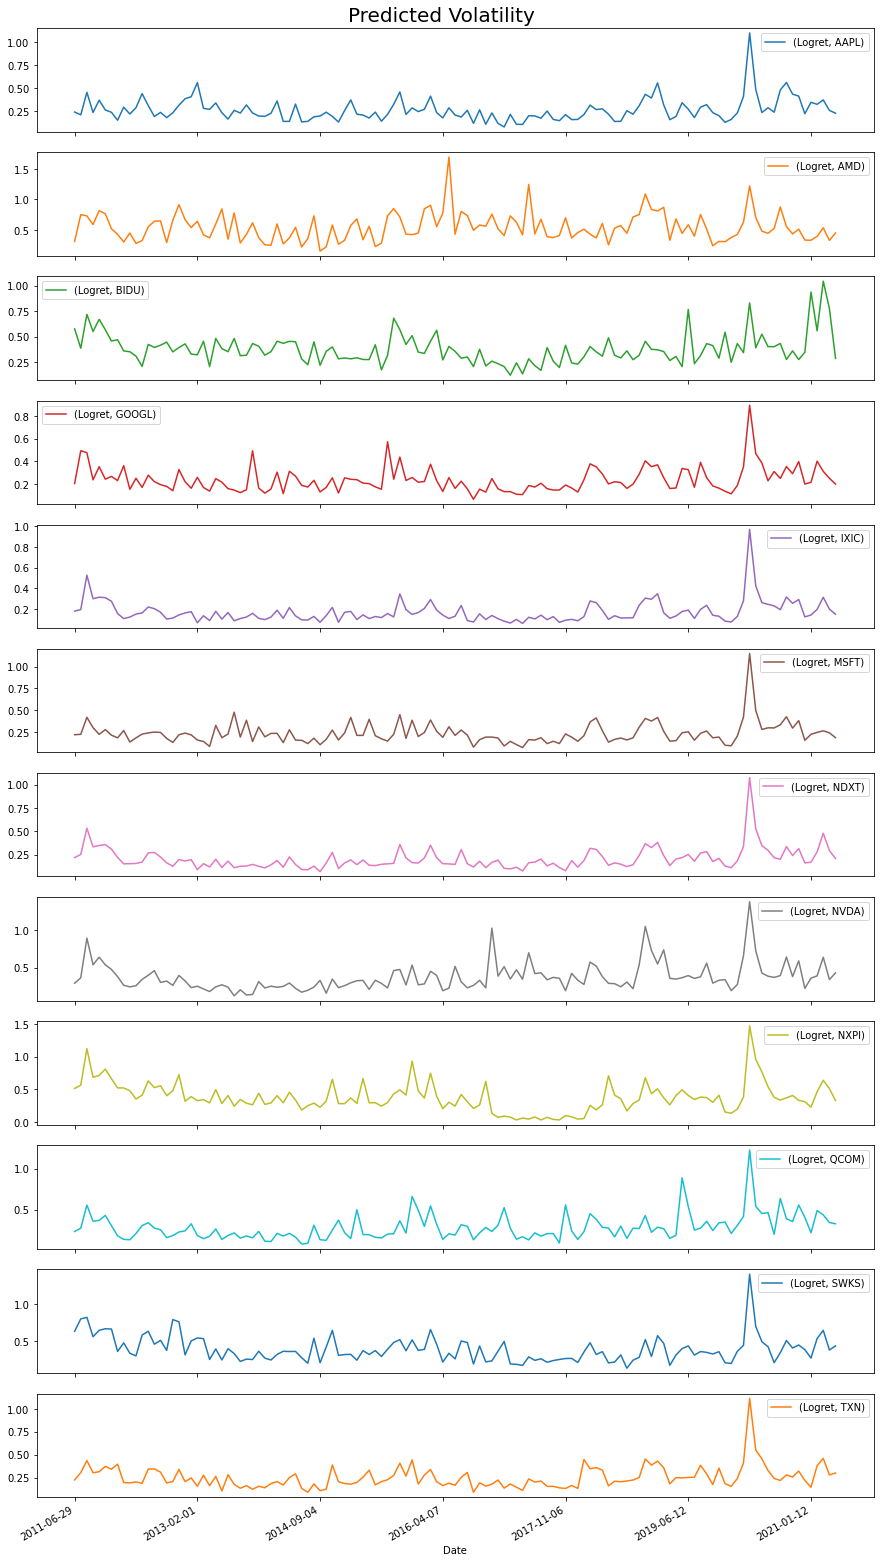

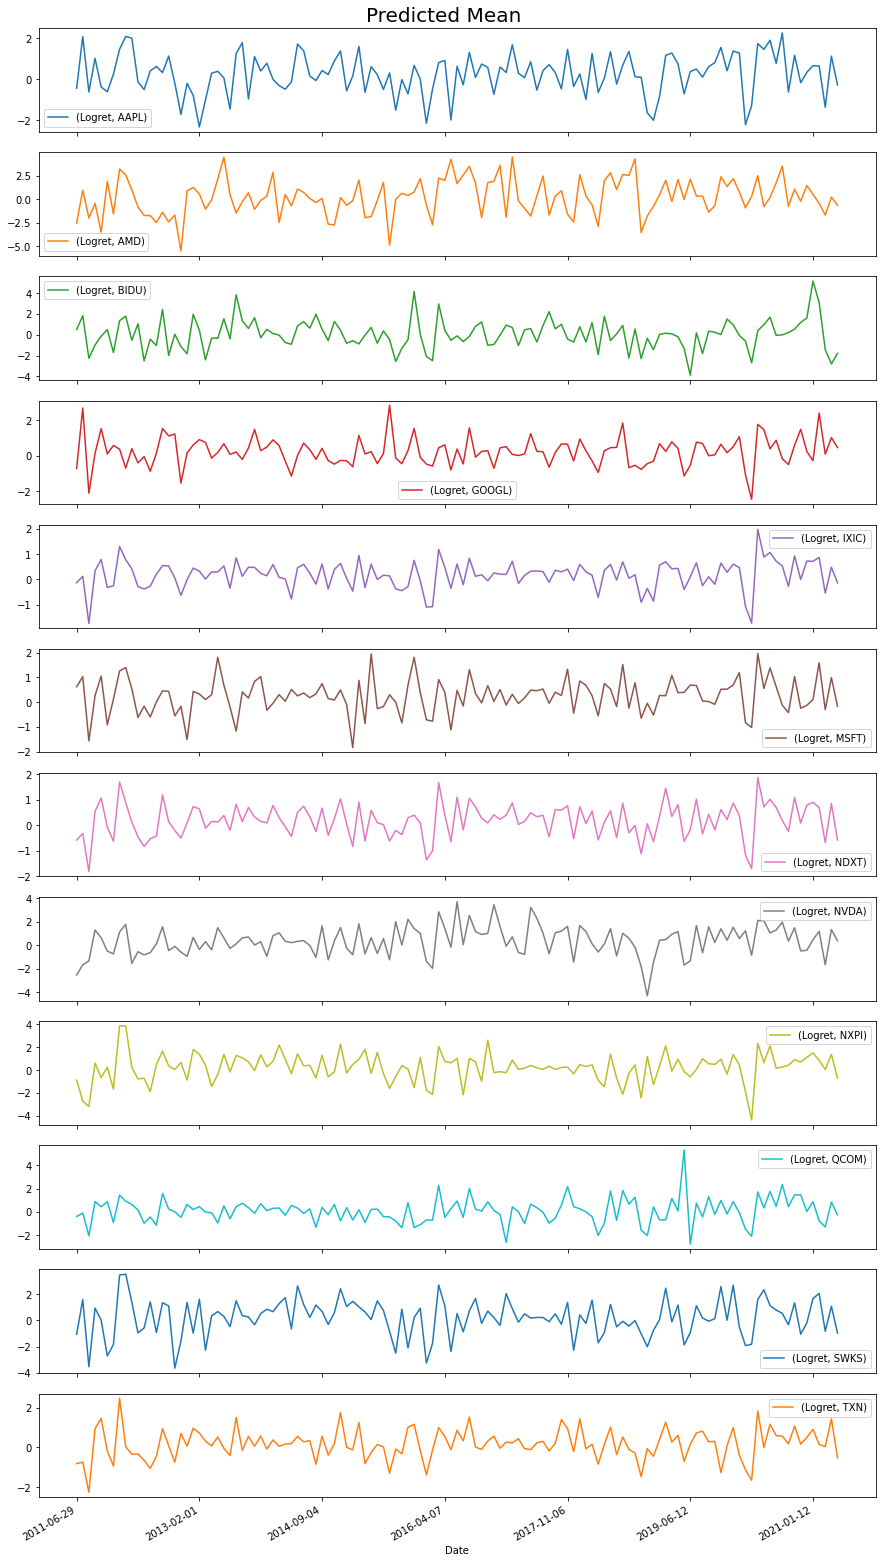

In [13]:
# visualize the predicted result forf volatility
volpred(logret, 20).plot(figsize = (15,30), subplots=True)
plt.suptitle("Predicted Volatility", fontsize = 20, y = 0.89)

# visualize the predicted result for mean
meanpred(logret, 20).plot(figsize = (15,30), subplots=True)
plt.suptitle("Predicted Mean", fontsize = 20, y = 0.89)

### Histograms of Errors

           APE (Volatility)                                                    \
ticker                 AAPL       AMD      BIDU     GOOGL      IXIC      MSFT   
Date                                                                            
2011-06-29         0.142340  0.584158  0.492660  0.586510  0.072769  0.020635   
2011-07-28         0.532389  0.028605  0.462816  0.036725  0.629553  0.465795   
2011-08-25         0.912651  0.241124  0.306258  1.013063  0.755752  0.394543   
2011-09-23         0.357805  0.278419  0.178909  0.329232  0.047113  0.343969   
2011-10-21         0.395168  0.064057  0.178907  0.452509  0.015375  0.195967   
...                     ...       ...       ...       ...       ...       ...   
2020-12-11         0.354143  0.012954  0.631336  0.073000  0.128371  0.305481   
2021-01-12         0.066458  0.163811  0.685996  0.464978  0.273856  0.092158   
2021-02-10         0.126313  0.259438  0.467453  0.288987  0.373047  0.066426   
2021-03-11         0.431299 

(None,
 array([[<AxesSubplot:title={'center':"('AMPE (Mean)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Mean)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Mean)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Mean)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'TXN')"}>]],
       dtype=object))

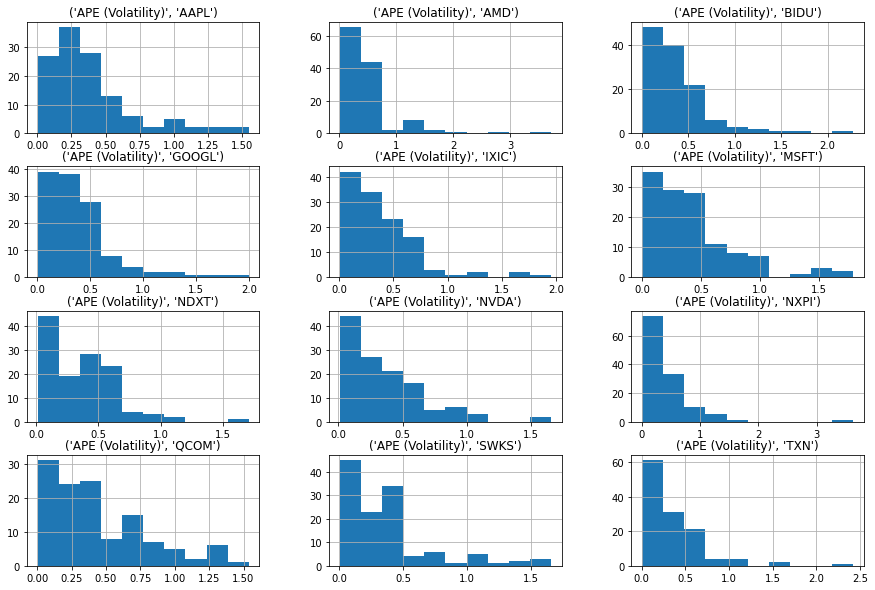

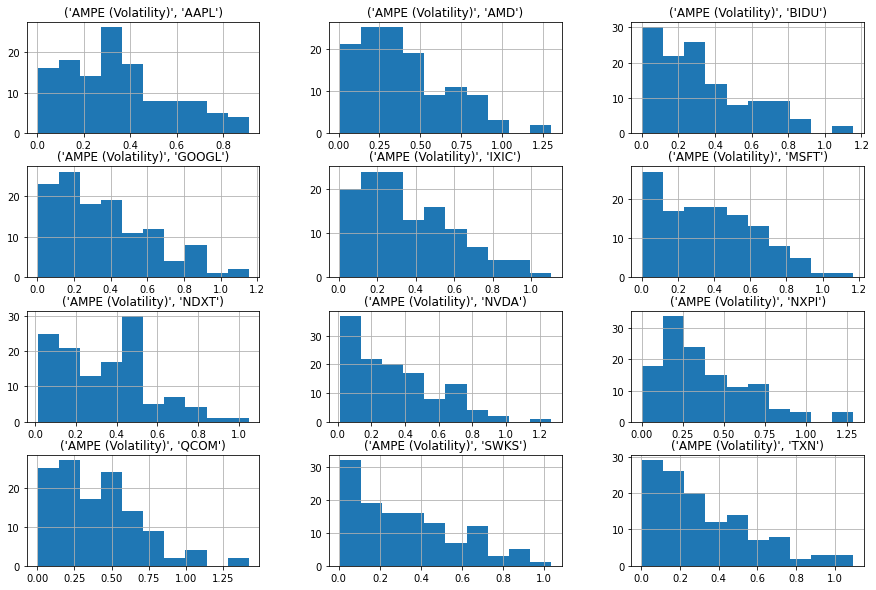

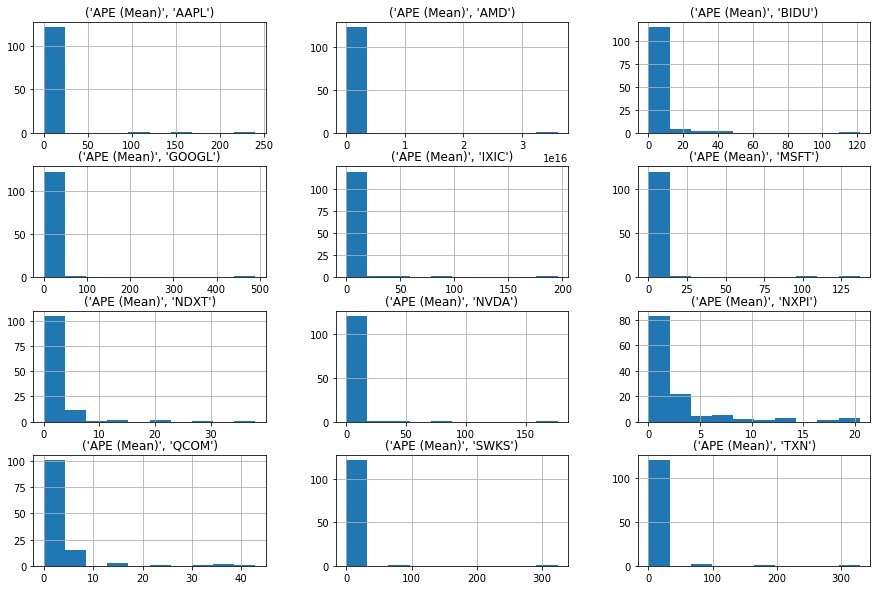

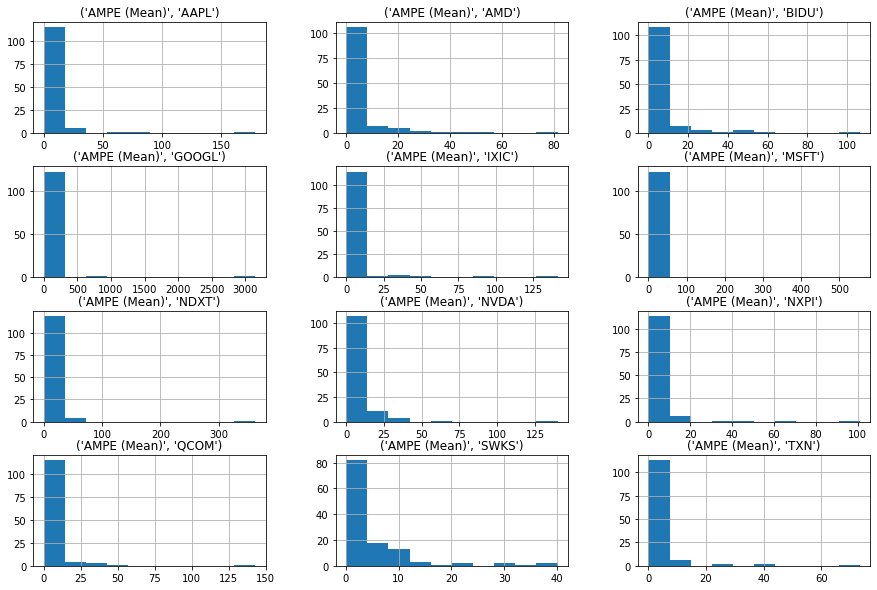

In [14]:
# APE, volatility, n=20
plothist(volAPE, 20)
# AMPE, volatility, n=20
plothist(volAMPE, 20)
# APE, mean, n=20
plothist(meanAPE, 20)
# AMPE, mean, n=20
plothist(meanAMPE, 20)

### Dot plots of percentage of errors greater than a chosen tail

Inf error exists when time window = []
NaN exists when time window = []
Inf error exists when time window = []
NaN exists when time window = []
Inf error exists when time window = []
NaN exists when time window = []
Inf error exists when time window = []
NaN exists when time window = []
Inf error exists when time window = [5, 30, 50, 55, 80]
NaN exists when time window = []
Inf error exists when time window = [5, 30, 50, 55, 80]
NaN exists when time window = []
Inf error exists when time window = [5, 10, 25, 35, 40]
NaN exists when time window = []
Inf error exists when time window = [5, 10, 25, 35, 40]
NaN exists when time window = []


<AxesSubplot:title={'center':'Mean, Percentage of error observations greater than tail=0.5, AMPE'}>

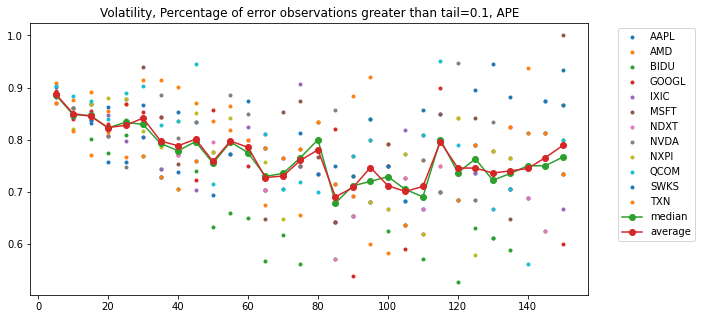

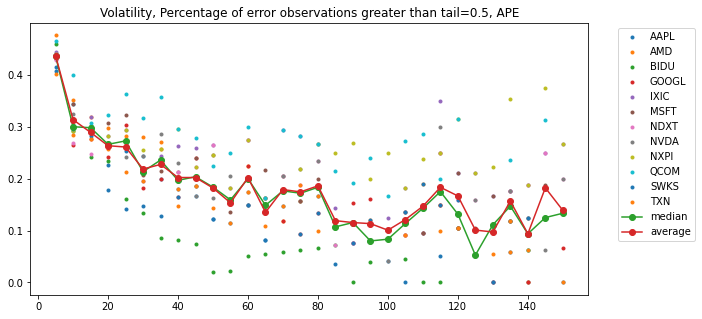

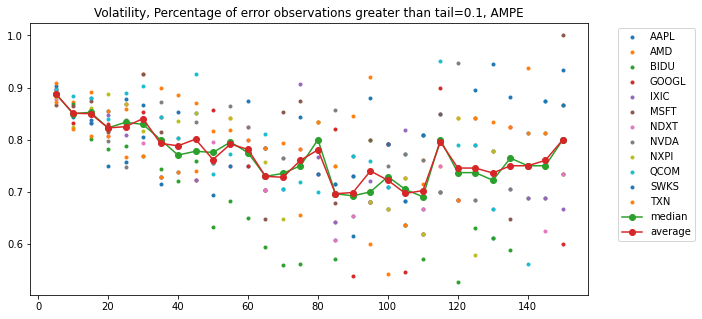

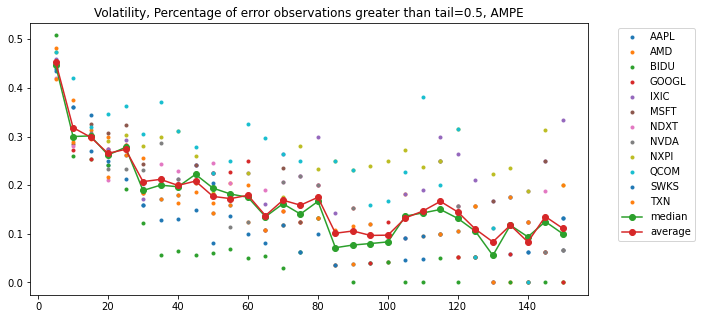

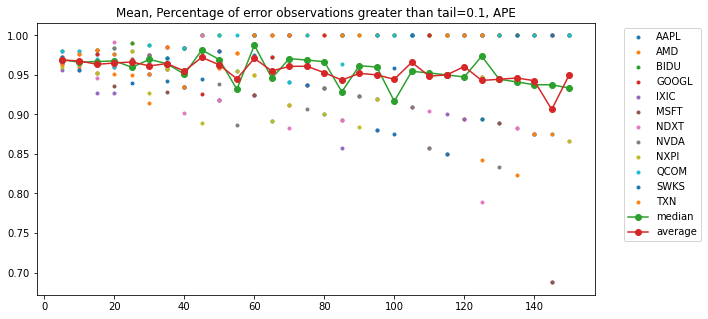

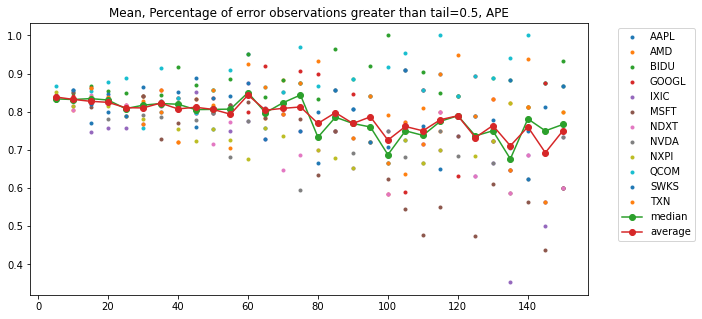

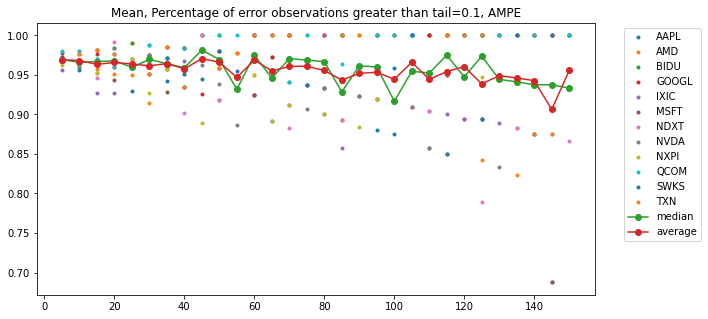

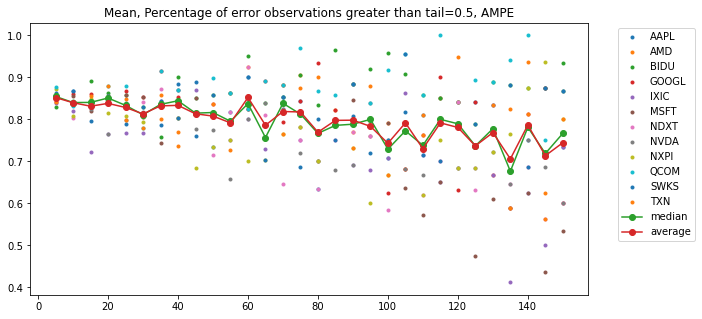

In [15]:
# APE, volatility, tail=0.1
plotdot(volAPE, 5, 150, 5, 0.1)[3]
# APE, volatility, tail=0.5
plotdot(volAPE, 5, 150, 5, 0.5)[3]
# AMPE, volatility, tail=0.1
plotdot(volAMPE, 5, 150, 5, 0.1)[3]
# AMPE, volatility, tail=0.5
plotdot(volAMPE, 5, 150, 5, 0.5)[3]

# APE, mean, tail=0.1
plotdot(meanAPE, 5, 150, 5, 0.1)[3]
# APE, mean, tail=0.5
plotdot(meanAPE, 5, 150, 5, 0.5)[3]
# AMPE, mean, tail=0.1
plotdot(meanAMPE, 5, 150, 5, 0.1)[3]
# AMPE, volatility, tail=0.5
plotdot(meanAMPE, 5, 150, 5, 0.5)[3]

### Dot plots of R-Squared

Inf error exists when time window = []
NaN exists when time window = []
Inf error exists when time window = []
NaN exists when time window = []


(None,
 None,
 ticker      AAPL       AMD      BIDU         GOOGL      IXIC      MSFT  \
 5       0.000043  0.000347  0.000896  7.415444e-03  0.002735  0.015540   
 10      0.003192  0.000740  0.001226  9.660056e-03  0.003396  0.023549   
 15      0.004875  0.000230  0.001798  1.569691e-02  0.022883  0.008575   
 20      0.005696  0.013373  0.010869  6.761375e-03  0.000089  0.013757   
 25      0.002917  0.003987  0.002041  2.795985e-02  0.013105  0.005294   
 30      0.000074  0.009175  0.004361  6.208925e-02  0.037068  0.050555   
 35      0.000171  0.004873  0.000647  6.734060e-02  0.053755  0.062730   
 40      0.000007  0.016767  0.002598  8.198480e-02  0.005218  0.006480   
 45      0.004395  0.061360  0.004925  9.266666e-02  0.002281  0.069956   
 50      0.006405  0.006567  0.000142  4.126457e-03  0.058610  0.101968   
 55      0.015126  0.022654  0.000311  1.473124e-01  0.014592  0.019032   
 60      0.017208  0.006468  0.005764  1.360286e-01  0.143942  0.165164   
 65      0.

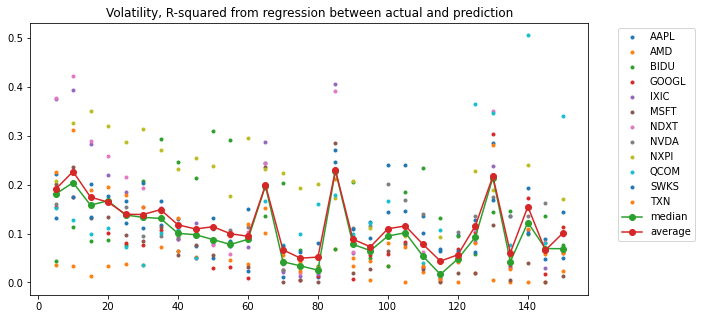

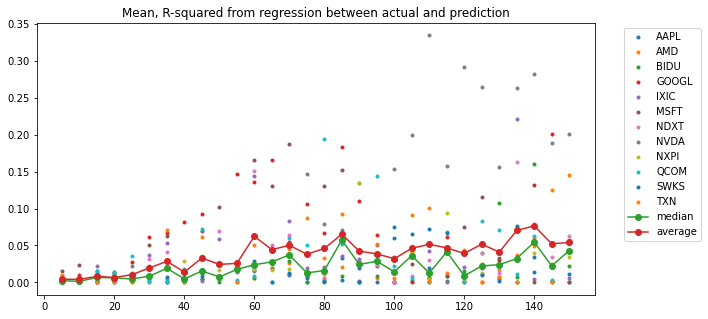

In [16]:
# volatility
plotr2(volpred, 5, 150, 5)
# mean
plotr2(meanpred, 5, 150, 5)